<a href="https://colab.research.google.com/github/han-jane/janehanlab/blob/master/magellan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and overview

This assignment is intended to give you practice analyzing and modeling behavioral data.  You'll be exploring and modeling how people learn their ways around a series of virtual reality environments.

## Background: the *Yellowcab* experimental paradigm

We'll be analyzing and modeling data from participants who ran in an experiment called *Yellowcab*. In the experiment, participants play the roles of [taxicab](https://en.wikipedia.org/wiki/Taxicab) drivers in a series of computer-generated "cities."  Each city is laid out on a rectangular grid of city blocks, with one landmark (building) centered on each block.  Several of the blocks in each environment are designated as "stores" that passengers (randomly placed throughout the virtual city) periodically ask to be delivered to.  The participant's goal is to accumulate points (virtual money); points are earned when a delivery is completed successfully, but points also decay over time as the participant drives through the environment (like spending gas money).

<img src=https://media1.tenor.com/images/5f5be51d269fe8da3dc3d3dbdc5b1c39/tenor.gif width=400px>

Researchers used an early version of this experiment to discover [human place cells](https://www.nature.com/articles/nature01964) in epilepsy patients they ran in the experiment using bedside laptop computers as they underwent [surgical monitoring](https://en.wikipedia.org/wiki/Electrocorticography).  A second variant of this experiment was later used to show that humans also have [grid cells](https://www.nature.com/articles/nn.3466).

Here we'll be examining a [behavioral dataset](https://github.com/ContextLab/magellan_data) comprising data from 107 participants who made 15 deliveries in each of 8 environments (for a total of 12,840 deliveries across all participants).  The dataset contains each participants' moment-by-moment locations and headings in the environments (sampled twice per second), as well as information about the task itself (e.g., the layouts of the environments participants navigated in, destinations of each passenger, etc.).

## Grading

This assignment is worth a total of 20 points.  There is no public rubric for this assignment-- use the examples in this notebook to test and debug your code.  To get full credit, you must follow the instructions below and (correctly) fill in all of the code between the `### BEGIN YOUR CODE` and `### END YOUR CODE` blocks throughout this notebook. (No other code should be modified.)

In [1]:
# Library imports-- take note of these aliases!
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import seaborn as sns
import datetime as dt
from glob import glob as lsdir
import os
import sys
import itertools
import random
from scipy.optimize import curve_fit

# Download the dataset and wrangle it into a convenient format

The `magellan_loader` module (alias: `ml`) contains a number of [helper functions](https://github.com/ContextLab/magellan_data#magellan_loader) that are used to wrangle the provided data.

In [2]:
root = 'magellan_data'
if not os.path.exists(root):
  !git clone https://github.com/ContextLab/magellan_data.git
  
  sys.path.insert(1, root)
  import magellan_loader as ml

Cloning into 'magellan_data'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 155 (delta 17), reused 22 (delta 9), pack-reused 125
Receiving objects: 100% (155/155), 165.01 MiB | 16.46 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Checking out files: 100% (119/119), done.


Let's use [`load_env`](https://github.com/ContextLab/magellan_data#load_env-load-in-information-about-the-environment-from-its-json-file) to load in the 8 environments (A--H) that participants navigated in the experiment.  We'll use the [`plot_environment`](https://github.com/ContextLab/magellan_data#plot_envs-plot-a-set-of-environments-by-calling-plot_environment-several-times) function to display them.  Stores (i.e., potential passenger destinations) are denoted using black circles; other landmarks are denoted using gray rectangles; and intersections (where two or more "streets" come together at each grid point) are denoted using gray dots.  The keys in the `envs` dictionary correspond to the environment's names, and the values contain a DataFrame describing each environment's [layout](https://github.com/ContextLab/magellan_data#load_env-load-in-information-about-the-environment-from-its-json-file):

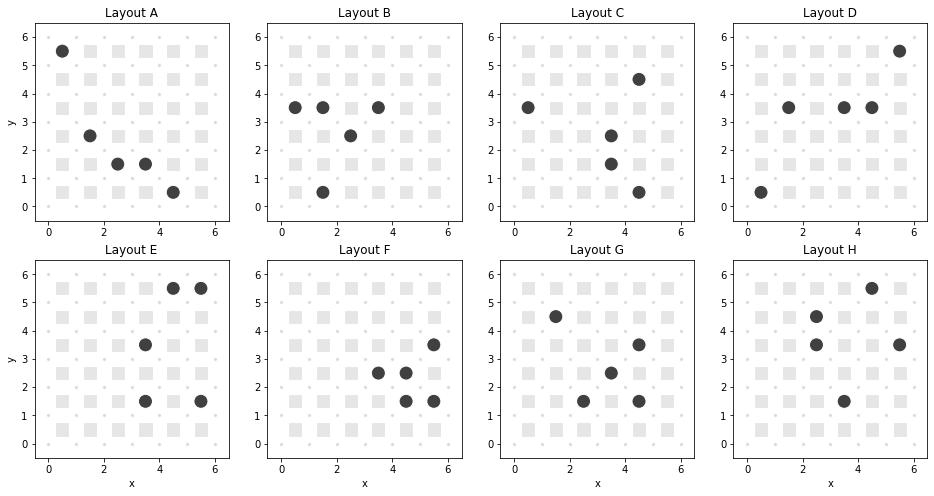

In [3]:
envs = {os.path.split(e)[-1].split('.')[0]: ml.load_env(e) for e in lsdir(os.path.join(root, 'env', '?.json'))}
ml.plot_envs(envs, [2, 4]);

We can also examine the first few rows of the DataFrame for an example environment:

In [4]:
example_env = 'A'
envs[example_env].head()

,x,y,type,delivery 1,delivery 2,delivery 3
Pet Store,0.5,5.5,store,1.0,6.0,15.0
b17-t4-1024x1024,1.5,5.5,landmark,NaN,NaN,NaN
b192-t20-1024x512,2.5,5.5,landmark,NaN,NaN,NaN
b20-t1-512x512,3.5,5.5,landmark,NaN,NaN,NaN
b47-t4-512x512,4.5,5.5,landmark,NaN,NaN,NaN


In [127]:
#envs[example_env]

,x,y,type,delivery 1,delivery 2,delivery 3
Pet Store,0.5,5.5,store,1.0,6.0,15.0
b17-t4-1024x1024,1.5,5.5,landmark,NaN,NaN,NaN
b192-t20-1024x512,2.5,5.5,landmark,NaN,NaN,NaN
b20-t1-512x512,3.5,5.5,landmark,NaN,NaN,NaN
b47-t4-512x512,4.5,5.5,landmark,NaN,NaN,NaN
b46-t7-512x512,5.5,5.5,landmark,NaN,NaN,NaN
b124-t15-512x1024,0.5,4.5,landmark,NaN,NaN,NaN
b91-t15-512x1024,1.5,4.5,landmark,NaN,NaN,NaN
b47-t20-1024x512,2.5,4.5,landmark,NaN,NaN,NaN
b22-t13-512x1024,3.5,4.5,landmark,NaN,NaN,NaN


In [77]:
#env_dataframe_sample = envs[example_env]

In [123]:
#index_wanted = env_dataframe_sample.drop(['x','y','type','delivery 1','delivery 2','delivery 3'], axis=1)

In [126]:
#index_wanted

""
Pet Store
b17-t4-1024x1024
b192-t20-1024x512
b20-t1-512x512
b47-t4-512x512
b46-t7-512x512
b124-t15-512x1024
b91-t15-512x1024
b47-t20-1024x512
b22-t13-512x1024


In [79]:
#env_dataframe_sample.loc['Pet Store'].x

0.5

Next, we'll use [`load_subj_data`](https://github.com/ContextLab/magellan_data#load_subj_data-load-in-one-subjects-behavioral-data-from-their-json-file) to load in the behavioral data from each of the 107 participants.  We'll display the delivery paths in each environment for one example participant using the [`plot_paths`](https://github.com/ContextLab/magellan_data#plot_paths-display-behavioral-data-from-each-session-environment-and-delivery-from-a-single-subject) function.

In [5]:
data = [ml.load_subj_data(s) for s in lsdir(os.path.join(root, 'data', 'MAG???.json'))]
print(f'Data from {len(data)} participants loaded successfully.')

Data from 107 participants loaded successfully.


In [133]:
data

[                                x         y     heading  ... env env_num delivery
 2010-06-30 13:29:17.588  3.000000  2.883377    0.000000  ...   A       0        0
 2010-06-30 13:29:17.604  3.000000  2.883466    0.000000  ...   A       0        0
 2010-06-30 13:29:17.622  3.000000  2.883597    0.000000  ...   A       0        0
 2010-06-30 13:29:17.639  3.000000  2.883775    0.000000  ...   A       0        0
 2010-06-30 13:29:17.655  3.000000  2.883994    0.000000  ...   A       0        0
 ...                           ...       ...         ...  ...  ..     ...      ...
 2010-07-07 21:09:08.000  4.563784  1.889866  249.909241  ...   E       3       14
 2010-07-07 21:09:08.500  4.773186  1.860547  259.593640  ...   E       3       14
 2010-07-07 21:09:09.000  4.972213  1.827711  259.274734  ...   E       3       14
 2010-07-07 21:09:09.500  5.143944  1.799607  253.525606  ...   E       3       14
 2010-07-07 21:09:10.000  5.280730  1.768780  243.873775  ...   E       3       14
 
 [

In [134]:
data[0]

,x,y,heading,mode,target,subj,session,env,env_num,delivery
2010-06-30 13:29:17.588,3.000000,2.883377,0.000000,forage,None,MAG001,0,A,0,0
2010-06-30 13:29:17.604,3.000000,2.883466,0.000000,forage,None,MAG001,0,A,0,0
2010-06-30 13:29:17.622,3.000000,2.883597,0.000000,forage,None,MAG001,0,A,0,0
2010-06-30 13:29:17.639,3.000000,2.883775,0.000000,forage,None,MAG001,0,A,0,0
2010-06-30 13:29:17.655,3.000000,2.883994,0.000000,forage,None,MAG001,0,A,0,0
...,...,...,...,...,...,...,...,...,...,...
2010-07-07 21:09:08.000,4.563784,1.889866,249.909241,seek,Grocery Store,MAG001,1,E,3,14
2010-07-07 21:09:08.500,4.773186,1.860547,259.593640,seek,Grocery Store,MAG001,1,E,3,14
2010-07-07 21:09:09.000,4.972213,1.827711,259.274734,seek,Grocery Store,MAG001,1,E,3,14
2010-07-07 21:09:09.500,5.143944,1.799607,253.525606,seek,Grocery Store,MAG001,1,E,3,14


In [142]:
data_index = 106 #0 -- len(data)
data[data_index]

,x,y,heading,mode,target,subj,session,env,env_num,delivery
2010-07-14 19:19:08.035,3.000000,2.883378,0.000000,forage,None,MAG033,0,E,0,0
2010-07-14 19:19:08.052,3.000000,2.883466,0.000000,forage,None,MAG033,0,E,0,0
2010-07-14 19:19:08.068,3.000000,2.883599,0.000000,forage,None,MAG033,0,E,0,0
2010-07-14 19:19:08.084,3.000000,2.883776,0.000000,forage,None,MAG033,0,E,0,0
2010-07-14 19:19:08.102,3.000000,2.883997,0.000000,forage,None,MAG033,0,E,0,0
...,...,...,...,...,...,...,...,...,...,...
2010-07-15 19:45:15.500,0.978756,4.446897,6.058538,seek,Pet Store,MAG033,1,A,3,14
2010-07-15 19:45:16.000,0.956095,4.662421,13.930025,seek,Pet Store,MAG033,1,A,3,14
2010-07-15 19:45:16.500,0.903370,4.872440,18.698674,seek,Pet Store,MAG033,1,A,3,14
2010-07-15 19:45:17.000,0.835435,5.078283,23.812816,seek,Pet Store,MAG033,1,A,3,14


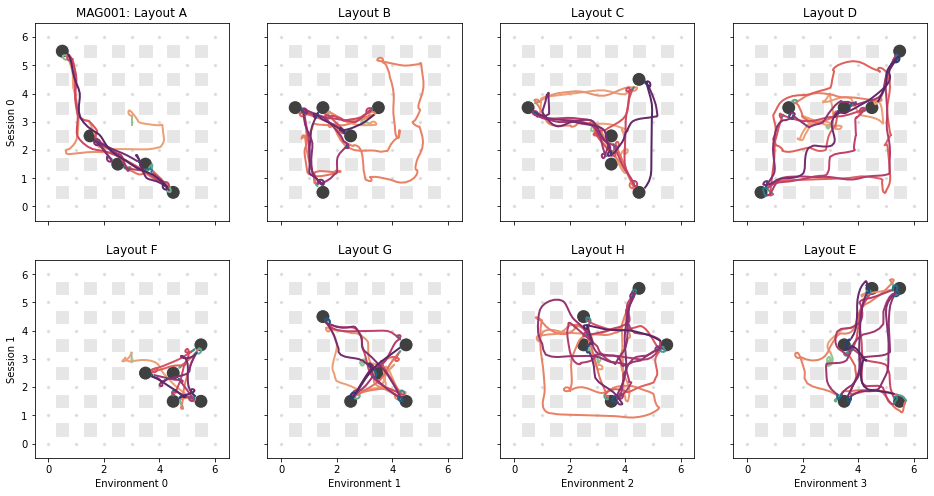

In [6]:
example_subj_ind = 0 #0 -- len(data)
ml.plot_paths(data[example_subj_ind], envs);

We can examine the first few rows of the DataFrame for the example participant:

In [7]:
data[example_subj_ind].head()

,x,y,heading,mode,target,subj,session,env,env_num,delivery
2010-06-30 13:29:17.588,3.0,2.883377,0.0,forage,None,MAG001,0,A,0,0
2010-06-30 13:29:17.604,3.0,2.883466,0.0,forage,None,MAG001,0,A,0,0
2010-06-30 13:29:17.622,3.0,2.883597,0.0,forage,None,MAG001,0,A,0,0
2010-06-30 13:29:17.639,3.0,2.883775,0.0,forage,None,MAG001,0,A,0,0
2010-06-30 13:29:17.655,3.0,2.883994,0.0,forage,None,MAG001,0,A,0,0


In [148]:
type(data[example_subj_ind])

pandas.core.frame.DataFrame

In [143]:
data[example_subj_ind]

,x,y,heading,mode,target,subj,session,env,env_num,delivery
2010-06-30 13:29:17.588,3.000000,2.883377,0.000000,forage,None,MAG001,0,A,0,0
2010-06-30 13:29:17.604,3.000000,2.883466,0.000000,forage,None,MAG001,0,A,0,0
2010-06-30 13:29:17.622,3.000000,2.883597,0.000000,forage,None,MAG001,0,A,0,0
2010-06-30 13:29:17.639,3.000000,2.883775,0.000000,forage,None,MAG001,0,A,0,0
2010-06-30 13:29:17.655,3.000000,2.883994,0.000000,forage,None,MAG001,0,A,0,0
...,...,...,...,...,...,...,...,...,...,...
2010-07-07 21:09:08.000,4.563784,1.889866,249.909241,seek,Grocery Store,MAG001,1,E,3,14
2010-07-07 21:09:08.500,4.773186,1.860547,259.593640,seek,Grocery Store,MAG001,1,E,3,14
2010-07-07 21:09:09.000,4.972213,1.827711,259.274734,seek,Grocery Store,MAG001,1,E,3,14
2010-07-07 21:09:09.500,5.143944,1.799607,253.525606,seek,Grocery Store,MAG001,1,E,3,14


In [147]:
print(data[example_subj_ind].target[31396])

Grocery Store


In [8]:
len(data[example_subj_ind].x)

31397

In [54]:
#path_sample = data[example_subj_ind].filter(['x','y'])

In [56]:
#path_sample.reset_index(drop=True)
##df.reset_index(drop=True, inplace=True)

,x,y
0,3.000000,2.883377
1,3.000000,2.883466
2,3.000000,2.883597
3,3.000000,2.883775
4,3.000000,2.883994
...,...,...
31392,4.563784,1.889866
31393,4.773186,1.860547
31394,4.972213,1.827711
31395,5.143944,1.799607


In [62]:
#path_sample.x[0]

3.0

# Spatial learning curves

The basic phenomenon we'll be exploring in this dataset is [spatial learning](https://en.wikipedia.org/wiki/Spatial_memory).  In particular, we'll ask: as a function of how much experience a participant has had navigating in or exploring an environment, how efficiently are they able to get around?

One way of characterizing the efficiency of a given path is to compute its *excess path length*.  If the navigated route has a length of $d_{obs}$ and the shortest possible (i.e., most efficient) route has a length of $d_{ideal}$, then the excess path length is given by $\mathrm{excess} = d_{obs} - d_{ideal}$.  We can then compute a *spatial learning curve* (i.e., excess path length as a function of the number of passengers a participant has delivered) to study the relation between experience (more deliveries means more experience) and efficiency (shorter excess paths means more efficiency).

To simplify our computations, we can approximate $d_{ideal}$ for a given path using the [city block distance](https://en.wikipedia.org/wiki/Taxicab_geometry) between the location where the passenger was picked up and the location where the passenger was dropped off at their requested destination (i.e., at the target store).  Effectively, this assumes that participants will generally drive in straight lines and make 90 degree turns.  Because this approximation is inexact, it is (in principle) possible for $\mathrm{excess}$ to be negative (e.g., since $d_{ideal}$ will nearly always be over-estimated).


## Helper functions

We can define several functions to help us approximate excess path lengths:
- `path_distance(path)`: compute the sum of the [Euclidean distances](https://en.wikipedia.org/wiki/Euclidean_distance) between each successive (x, y) point on the given path:
  - `path` is provided as a DataFrame with `x` and `y` columns (specifying the x and y positions at each timepoint).
  - Assume that the path will come from a single delivery (no need to check any columns aside from `x` and `y`).
  - Each row of the DataFrame corresponds to a single timepoint.
  - Assume that the timepoints are ordered from earliest (first row) to latest (last row), and that there are no "skipped" or "missing" observations.
  - Return a single scalar (type: `float`) containing the total length of the path.  We will use this quantity as $d_{obs}$.
- `adjacent_intersections(b, blocksize=1)`: given the center coordinates of the block a landmark is centered on, compute the coordinates of the four nearest intersections.
  - `b` is a single location, specified as a dictionary, Series, or DataFrame (with a single row).  `b['x']` should yield the x-coordinate of the location and `b['y']` should yield the y-coordinate.
  - `blocksize` is an optional argument (default value: 1) specifying how large blocks are (in arbitrary units).  Adjacent intersections are at (`b['x']` $\pm \frac{\mathrm{blocksize}}{2}$, `b['y']` $\pm \frac{\mathrm{blocksize}}{2}$).
  - Return the coordinates of the four adjacent intersections as rows of a DataFrame with columns `x` and `y`.  The rows can be returned in any order.
- `cityblock_distance(path, destination, env, blocksize=1)`: return the [city block distance](https://en.wikipedia.org/wiki/Taxicab_geometry) between the starting coordinate of the given `path` and the nearest intersection that is adjacent to the given `destination`:
  - `path` is provided as a DataFrame with `x` and `y` columns (specifying the x and y positions at each timepoint).  Assume it's in the same format as described above for the `path_distance` function.
  - `destination` is a string specifying the target the participant is seeking during the given path.
  - `env` is a DataFrame specifying the environment's [layout](https://github.com/ContextLab/magellan_data#load_env-load-in-information-about-the-environment-from-its-json-file).  The relevant features of the `env` DataFrame are:
    - The rows are indexed by structure names; `env.loc[destination]` will return the row with information about the participant's target.  (You can assume that `destination` will always be one of the indexed rows of `env`.)
    - The `x` and `y` columns specify the x and y coordinates of the corresponding structure.
  - `blocksize` is an optional argument (default value: 1) specifying how large blocks are (in arbitrary units).  It is required here solely for passing on to the `adjacent_intersections` function.
  - The function should return a `float` reflecting the city block distance from the starting coordinate (`path.[['x', 'y']].iloc[0]`) to the nearest intersection adjacent to `env.loc[destination].[['x', 'y']]`.  We'll use this as our estimate of $d_{ideal}$.

In [12]:
#starting_coordinate = [1,2]

In [14]:
#starting_coordinate[1]

2

In [90]:
#  destination_coordinate = [0,0]
#  destination_coordinate[0] = env_dataframe_sample.loc['Pet Store'].x
#  destination_coordinate[1] = env_dataframe_sample.loc['Pet Store'].y
#  #the nearest intersection
#  b = pd.DataFrame([destination_coordinate], columns=['x','y'])

In [198]:
def path_distance(path):
  ### BEGIN YOUR CODE
  delta_distance_mat = np.zeros(len(path.x)-1)
  delta_distance = 0

  path.reset_index(drop=True)
  for i in range(len(path.x)-1):
    index = i+1
    if path.x[index] == path.x[index-1]:
      delta_distance = abs(path.y[index]-path.y[index-1])
    elif path.y[index]==path.y[index-1]:
      delta_distance = abs(path.x[index]-path.x[index-1])
    delta_distance_mat[i] = delta_distance
  
  d_obs = sum(delta_distance_mat)
  return d_obs
  ### END YOUR CODE

def adjacent_intersections(b, blocksize=1):
  ### BEGIN YOUR CODE
  delta_block = (blocksize/2)
  #initialize
  intersections = pd.DataFrame(np.zeros((4,2)), columns=['x', 'y'])
  #allocate
  intersections['x'][0] = b['x']-delta_block
  intersections['y'][0] = b['y']-delta_block

  intersections['x'][1] = b['x']-delta_block
  intersections['y'][1] = b['y']+delta_block

  intersections['x'][2] = b['x']+delta_block
  intersections['y'][2] = b['y']-delta_block

  intersections['x'][3] = b['x']+delta_block
  intersections['y'][3] = b['y']+delta_block
  return intersections
  ### END YOUR CODE

def cityblock_distance(path, destination, env, blocksize=1):
  ### BEGIN YOUR CODE
  #starting coordinate : path
  path.reset_index(drop=True)
  

  starting_coordinate = [0,0]
  starting_coordinate[0] = path.x[0]
  starting_coordinate[1] = path.y[0]
  #destination (x,y) coordination in the given env : destination, env
  destination_coordinate = [0,0]

  #env.reset_index(drop=True)
  env2 = pd.DataFrame.from_dict(env)
  env2.reset_index(drop=True)
  
  destination_coordinate[0] = env2.loc[destination].x[0]
  destination_coordinate[1] = env2.loc[destination].y[0]
  #the nearest intersection
  #city block distance calculation
  b = pd.DataFrame([destination_cooridnate], columns=['x','y'])
  intersections = adjacent_intersections(b, blocksize)
  delta_intersections = abs(intersections-starting_coordinate)
  min_x = min(delta_intersections.x)
  min_y = min(delta_intersections.y)
  d_ideal = (min_x+min_y)
  return d_ideal
  ### END YOUR CODE

## Computing the average learning curve

Now we can put the above helper functions together to compute a complete learning curve.  The `learning_curve` function below takes in a dataset and returns the excess path lengths for each delivery:
- `data` can be either a single participant's data (e.g., as produced by [`load_subj_data`](https://github.com/ContextLab/magellan_data#load_subj_data-load-in-one-subjects-behavioral-data-from-their-json-file)), or a list of multiple participants' data (e.g., as produced by `[ml.load_subj_data(s) for s in fnames]`, as above).
- `envs` is the dictionary of environment DataFrames (whose keys are environment names), as defined above.
- `blocksize` is an optional argument (default value: 1) specifying how large blocks are (in arbitrary units).  It is required here solely for passing on to the `cityblock_distance` function.
- `pivot` is an optional argument (default value: `False`) that specifies whether the [`pandas.DataFrame.pivot`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html) function is applied to the output of the `learning_curve` function before returning the excess path lengths:
  - When `pivot` is `False`, the `x` DataFrame that `learning_curve` returns should be organized as follows:
    - Index: arbitrary (e.g., 0 ... (`x.shape[0] - 1`))
    - Columns (all of these except `excess path` are read and/or obtained from `data`):
      - `target`: The target store for the given delivery (e.g., `'Gym'`)
      - `subj`: The subject's unique ID (e.g., `'MAG062'`)
      - `session`: The session number of the given delivery (either 0 or 1)
      - `env`: The given environment's unique letter code (e.g., `'B'`)
      - `env_num`: The environment's index within the current session (0, 1, 2, or 3).  (Note the `'_'` between `env` and `num`.)
      - `delivery`: The number (0 -- 14) of the current delivery.
      - `excess path`: The excess path length of the current delivery-- i.e., path distance - city block distance.  (Note the `' '` between `excess` and `path`.)
  - When `pivot` is `True`, the `x` DataFrame that `learning_curve` returns should instead be organized as follows (hint: use [`pandas.DataFrame.pivot`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html)!):
    - Index: a [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html) comprising each unique (`subj`, `session`, `env`) tuple.  In other words, the index of each row of the DataFrame should correspond to a unique subject, session, and environment letter code.
    - Columns: 0, 1, 2, ...., 14 (one per `delivery`)
    - Values: the excess path lengths for each (`subj`, `session`, `env`) and `delivery`.  In other words, if each of *p* participants navigates *n* environments across their two testing sessions, then the final DataFrame should have *np* rows and 15 columns.

### Hints:
- The [`apply_by_condition`](https://github.com/ContextLab/magellan_data#apply_by_condition-apply-a-function-to-data-corresponding-to-each-combination-of-unique-values-from-the-given-columns) applies a given function (in this case, `excess_path_length`) to subsets of the DataFrame `data` that exhibit each unique combination of the given columns (in this case, `subj`, `session`, `env_num`, and `delivery`).  Here that function manages a complicated bookkeeping job of calling the `excess_path_length` function for each combination of those columns.
- When you write the `excess_path_length` function, assume that `x` is a DataFrame containing the `seek` path for a single delivery, from a single environment, from a single session, from a single participant.  In other words, `x` can be passed directly to the `path_distance` and `cityblock_distance` functions that you wrote above.
- The `envs` and `blocksize` variables referenced in the body of the definition of `excess_path_length` will have the same values as in the body of the parent function (`learning_curve`) because of how they're passed to `apply_by_condition`.
- There is at least one "complicated" way to write the pivot code and at least one "easy" way to write the pivot code.  The easy way entails using [`pandas.DataFrame.pivot`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html), and I strongly encourage you to use that function rather than coding that portion from scratch.  You can do the pivot in a single line of code, once you compute the default ("`pivot == False`") version of the excess path lengths DataFrame.
- The return value of `excess_path_length` can be anything you think will be convenient.  Those returned values (for each unique combination of `subj`, `session`, `env_num`, and `delivery`) will be aggregated into the list `excess`.  You'll then need to write some code to aggregate those values into a single DataFrame.

In [202]:
def learning_curve(data, envs, blocksize=1, pivot=False):
  if type(data) == list:
    return pd.concat([learning_curve(d, envs, blocksize=blocksize, pivot=pivot) for d in data])
  
  def excess_path_length(x, envs, blocksize):
    ### BEGIN YOUR CODE
    ##### where is this x coming from???
    ##### it has to be fed by apply_by_condition somehow...
    # calculate d_obs
    d_obs = path_distance(x)

    # calculate d_ideal
    ### destination not needed as it is a single delivery????
    ### thus the destination is the last point of the delivery??
    destination = x.target[0] 
    d_ideal = cityblock_distance(x, destination, envs, blocksize=blocksize)

    d_exess = d_obs - d_ideal
    return d_excess
    ### END YOUR CODE

  excess = ml.apply_by_condition(data.query('mode == "seek" or mode == "autopilot"'), ['subj', 'session', 'env_num', 'delivery'], excess_path_length, args=[envs, blocksize])
  
  ### BEGIN YOUR CODE
  ##### excess is a list
  #lc = excess # I want to see it
  
  ##### aggregate those values into a single DataFrame
  ###default pivot=="False"
  #initialize
  lc = data.filter(['target','subj','session','env','env_num','delivery'])
  lc['excess path'] = excess
  

  if pivot == "True":
    lc = lc.pivot(index=["subj","session","env"],columns=[range(15)], values='excess path')

  return lc
  ### END YOUR CODE

In [203]:
lc = learning_curve(data,envs,blocksize=1, pivot=False)
lc
# could not debug this part...

ValueError: ignored

In [108]:
#for i in range(len(data)):
#  if data[i].subj[0]=="MAG062":
#    print(i)

In [107]:
#data[61].query('mode == "seek" and delivery == 0 and env == "A"') 

Here's what your learning curve should look like:

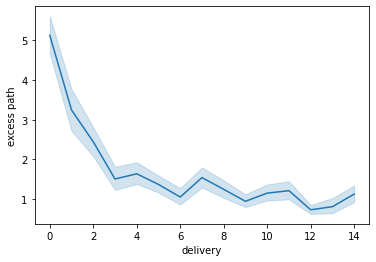

In [ ]:
lc = learning_curve(data, envs)
sns.lineplot(data=lc, x='delivery', y='excess path', legend=False);

# Modeling learning as an *equation*

The above learning curve shows that the average inefficiency with which partipants delivery passengers decays roughly [exponentially](https://en.wikipedia.org/wiki/Exponential_decay) with the number of deliveries.

This suggests one way of "modeling" learning: we could fit an exponential decay function to the learning curve.  This is a model in the sense that it will allow us to "predict" or "explain" the rate with which path inefficiencies decrease with each successive delivery.

Let's make use of the `pivot` keyword argument to compute the learning curve for each participant and environment.  Then we'll use `groupby` to compute the average learning curve (across environments) for each participant:

In [204]:
subj_learning_curves = learning_curve(data, envs, pivot=True).groupby('subj').mean()

ValueError: ignored

Then we'll need to define our decay function.  Let's define `decay` to take in a numpy array of delivery numbers (`x`), along with three additional parameters: `rate`, `scale`, and `offset`.  The function should return a new vector, `y`, where each value is given by $\mathrm{scale} \cdot \exp\{-x \cdot \mathrm{rate}\} + \mathrm{offset}$.

In [109]:
def decay(x, rate, scale, offset):
  ### BEGIN YOUR CODE
  y = (scale * np.exp((-x)*rate)) + offset
  return y
  ### END YOUR CODE

We can get a feel for the `decay` function using some test parameters:

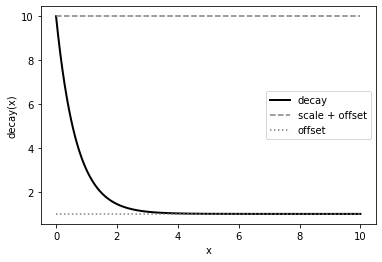

In [110]:
x = np.linspace(0, 10, num=1000)
rate = 1.5
scale = 9
offset = 1
mpl.pyplot.plot(x, decay(x, rate, scale, offset), color='k', linewidth=2) #decay
mpl.pyplot.plot([np.min(x), np.max(x)], [scale + offset, scale + offset], '--', color='gray')
mpl.pyplot.plot([np.min(x), np.max(x)], [offset, offset], ':', color='gray')
ax = mpl.pyplot.gca()
ax.set_xlabel('x')
ax.set_ylabel('decay(x)')
ax.legend(['decay', 'scale + offset', 'offset']);

Now use the [SciPy `curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function to estimate the `rate`, `scale`, and `offset` parameters that best explain a given learning curve, `lc` (where `lc` is an array with number-of-deliveries elements, containing the excess path lengths for each delivery-- e.g., a row of `subj_learning_curves`).  The parameters `p0` (initial guess for `rate`, `scale`, and `offset`, respectively), `bounds` (lower and upper bounds for each parameter), and `maxfev` (maximum number of function evaluations before an exception is raised) should be left at the default values specified below (and passed into `curve_fit` as keyword arguments):

In [ ]:
def fit(lc, p0=[0.5, 5, 1], bounds=[[0, 0.1, 0], [1, 10, 5]], maxfev=int(1e6)):
  ### BEGIN YOUR CODE
  rate = p0[0]
  scale = p0[1]
  offset = p0[2]
  f = decay(lc.x, rate, scale, offset)

  xdata = lc.x
  ydata = lc.y

  rate, scale, offset = sp.optimize.curve_fit(f, xdata, ydata, bounds=bounds)  

  return rate, scale, offset
  ### END YOUR CODE

As a test, let's try fitting our decay function to the *average* learning curve:

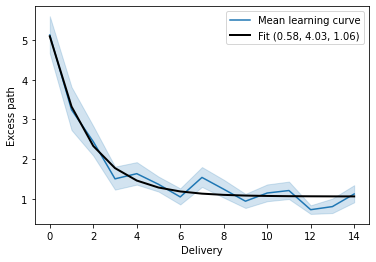

In [ ]:
random.seed(3755)
x = range(subj_learning_curves.shape[1])
rate, scale, offset = fit(subj_learning_curves.mean(axis=0))
sns.lineplot(data=lc, x='delivery', y='excess path', legend=False);
mpl.pyplot.plot(x, decay(x, rate, scale, offset), color='k', linewidth=2)
ax = mpl.pyplot.gca()
ax.set_xlabel('Delivery')
ax.set_ylabel('Excess path')
ax.legend(['Mean learning curve', f'Fit ({rate:0.2f}, {scale:0.2f}, {offset:0.2f})']);

Next, let's fit a decay function independently for each participant.  We'll get a distribution of `rate`, `scale`, and `offset` parameters (with one value per participant).  Fill in the function below to return a DataFrame (indexed by participant) with each participant's `rate`, `scale`, and `offset` parameters.

In [ ]:
def multi_fit(lc, **kwargs):
  ### BEGIN YOUR CODE
  
  return subj_params
  ### END YOUR CODE

In [ ]:
random.seed(6207)
subj_params = multi_fit(subj_learning_curves)
subj_params.head()

,rate,scale,offset
subj,,,
MAG001,0.26472,3.52814,0.302741
MAG002,1,7.39888,0.699813
MAG003,0.0663469,2.7961,1.6496e-12
MAG004,1,1.94053,1.19613
MAG005,0.698446,2.42496,0.663861


We can also examine the distributions of each parameter and the covariation between pairs of parameters:

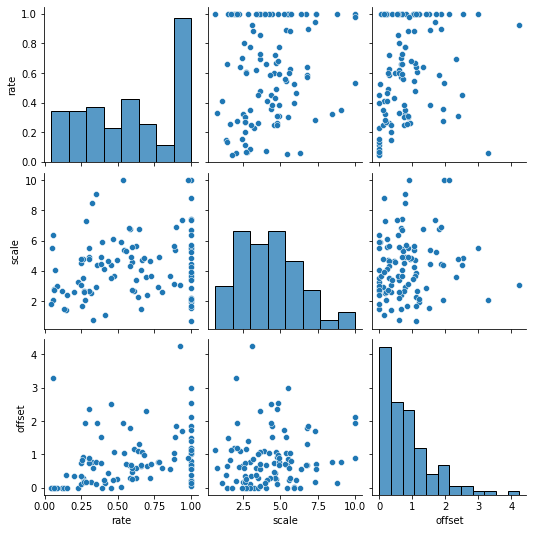

In [ ]:
sns.pairplot(subj_params);

To think about (but no specific actions required):
- Might the boundaries specified for `rate`, `scale`, and/or `offset` need adjusting?  Why or why not?
- How could we interpret the values of `rate`, `scale`, and/or `offset` as psychological variables of interest?

# Modeling learning as a *process*: the MAGELLAN model

Although curve fitting can be a valuable way of modeling data, the decay function we implemented above does not (and is not intended to) explain *how* participants' excess path lengths might come to be.

Next, we'll try a very different approach to modeling the behavioral data from the Yellowcab paradigm by implementing a (slightly simplified) version of the [MAGELLAN model](https://psycnet.apa.org/record/2014-03908-001).  This model describes (explicitly) how people might build up a cognitive map representation of unfamiliar environments.  (The model's name is inspired by [Ferdinand Magellan](https://en.wikipedia.org/wiki/Ferdinand_Magellan), shown below, who is credited with organizing the first expedition to circumnavigate the Earth.)

<img src=https://upload.wikimedia.org/wikipedia/commons/9/9c/Ferdinand_Magellan.jpg width="250">

The MAGELLAN model is built on a set of simple rules that describe how a navigator's mental representation of their environment might change over time:
1. A *map* is defined as a set of spatial landmarks, along with their estimated locations in the environment.  Each landmark is associated with a *memory strength* that varies between 0 and 1, inclusive.  A memory strength of 0 denotes that no information about the given landmark is present in the cognitive map.  As a landmark's memory strength increases, its representation in the map becomes easier to access.
2. A *vision* function determines how sensory information about the surrounding environment is incorporated into the map.  Spatial landmarks that are "perceived" by the vision function are assigned a memory strength of 1.  For the purposes of this assignment, the vision module will be parameterized by a single parameter, $x_1$.  When the navigator is within $x_1$ distance units of a given landmark, we assume that the landmark has been perceived.
3. A *memory* function determines how information in the map changes over time:
  - Each landmark's memory strength decays over time (this simulates forgetting).  A decay parameter, $x_2$, controls the decay rate.
  - While a landmark's memory strength is above a threshold, $x_3$, the navigator is able to access that landmark's location in the map.  When the landmark's strength falls below $x_3$, information about the landmark is no longer available.

The model also describes how the map may be used to navigate to a known location in the environment, or search for an unknown location:
1. The target's location is "known" if its strength is at least $x_3$.  If the current target is known, then MAGELLAN generates (and follows) an efficient path towards the target.
2. If the current target is unknown, MAGELLAN enters a "search" mode:
  - A "temporary target" is selected at random from the closest set of possible locations that the target might be, given what is known about the locations of *other* landmarks.
  - Once a temporary target is selected, MAGELLAN takes a single step towards the temporary target (using the vision function to update the map, and the memory function to decay the memory strengths as appropriate).
  - Next, MAGELLAN again re-evaluates whether the target location is known (and if so, navigates to it) or unknown (in which case a new temporary target is selected).  This process repeats until the navigator arrives at the target.

When we "fit" MAGELLAN to a spatial navigation dataset, we are (at some level) testing the assumptions we've embedded into the model.  In other words, we are asking: if we assume *this* is how navigation works (where "this" is the set of assumptions and definitions outlined above), to what extent can we explain spatial learning?  For example:
- Can we use MAGELLAN to predict what information is available in people's cognitive maps at a given point in time?
- Can we use MAGELLAN to predict which environments might be easy or difficult for people to learn to navigate in?
- What are the "degrees of freedom" in how people decide to navigate?  If and when "random" decisions are made, how do those decisions propagate to affect learning and/or future behaviors?

# Building MAGELLAN
## Part 1: defining the `Map` class

MAGELLAN assumes that spatial representations are stored in a cognitive map.  We'll define a `Map` class below to help us with bookkeeping and visualization of the contents of the map.  Your job is to fill in the `__getitem__` and `__setitem__` functions:
- `__getitem__(self, key)`: given a `key` (a string representation of any landmark stored in the given `Map`, a list or array of landmark's strings, or a DataFrame or Series indexed by landmark strings), return the corresponding memory strengths for those landmarks.  This function makes it possible to index `Map` objects using square bracket notation.
- `__setitem__(self, key, val)`: given a `key` (specified using the same requirements as for `__getitem__`), and one or more values (`val`), set the memory strengths of the landmarks specified by `key` to the values specified by `val`.  Note that `val` must either be a scalar (in which case all strengths should get set to the same value) or a list or array of the same length as the number of keys (i.e., one value per key).

In [ ]:
class Map():    
  def __init__(self, env, blocksize=1, offset=0):
    width, height = ml.get_env_dims(env)
    self.blocksize = blocksize
    self.offset = offset
    self.strengths = pd.DataFrame(np.zeros([height, width]), index=np.arange(0.5, height), columns=np.arange(0.5, width))
    self.env = env
    
    self.names = self.strengths.copy()
    
    coords = self.coords2blocks(np.array((env[['x', 'y']] - 0.5).values))        
    for i in range(coords.shape[0]):
      self.names.iloc[coords[i, 1], coords[i, 0]] = env.index[i]
    
    self.names = self.names.values
  
  def coords2blocks(self, x):
    return np.array(np.divide(x + self.offset, self.blocksize), dtype=int)
  
  def __getitem__(self, key):
    ### BEGIN YOUR CODE
    pass
    ### END YOUR CODE
  
  def __setitem__(self, key, val):
    ### BEGIN YOUR CODE
    pass
    ### END YOUR CODE
  
  def plot(self, cbar=True, cmap='Blues'):
    width, height = ml.get_env_dims(self.env)
    
    sns.heatmap(data=self.strengths, vmin=0, vmax=1, cbar=cbar, cbar_kws={'label': 'strength'}, cmap=sns.color_palette(cmap, as_cmap=True))
    ax = ml.plot_environment(self.env)

    ax.set_xticks(np.arange(0, width + 1))
    ax.set_xticklabels(np.arange(0, width + 1))
    ax.set_yticks(np.arange(0, height + 1))
    ax.set_yticklabels(np.arange(0, height + 1))

    ax.add_patch(mpl.patches.Rectangle([-0.45, -0.45], width + 0.9, height + 0.9, facecolor='none', edgecolor='k', linewidth=1))

    return ax

Let's test out the `Map` object.  First we'll initialize a new `Map` using environment A:

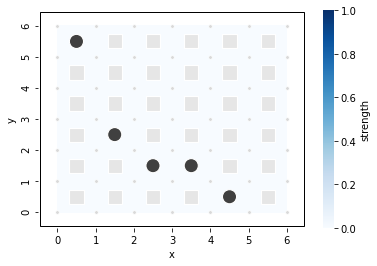

In [ ]:
m = Map(envs['A'])
m.plot();

Now we can set the strengths of all of the stores in the map to 1 and verify that they've been updated correctly:

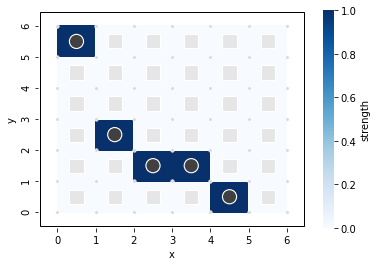

In [ ]:
m[['Pet Store', 'Butcher Shop', 'Camera Store', 'Shoe Store', 'Ice Cream Shop']] = 1
m.plot();

## Part 2: defining some helper functions

Next we'll define some useful functions to help us when we implement the full model:
- `dists_to_landmarks(coord, env)`: compute the Euclidean distance from location specified in `coord` to each location in the environment `env`:
  - `coord` is a Series or 1-row DataFrame with `x` and `y` attributes (or columns) specifying the reference location.
  - `env` is a DataFrame for an environment (same format as in previous functions)
  - The function should return a 1D array of the distances from `coord` to each landmark (row) of `env`.
- `closest_landmarks(coord, env)`: compute the landmarks that are closest to the given location
  - `coord` and `env` are defined the same as in `dists_to_landmarks`
  - The function should return a DataFrame comprising the row(s) of `env` that are closest (in Euclidean distance) to `coord`.
- `get_nearby_structures(coord, env, tol)`: compute the landmarks that are within a specified Euclidean distance of the given location:
  - `coord` and `env` are defined the same as in `dists_to_landmarks`
  - `tol` is a positive scalar specifying the maximum distance threshold that should be considered-- any landmarks within `tol` units of `coord` are considered "nearby"
  - The function should return a DataFrame comprising the row(s) of `env` that are within `tol` units of `coord`
- `memory_decay(x, rate, d)`: describes how memory strengths decay over time:
  - `x`: an array (or scalar) specifying the memory strength(s)
  - `rate`: decay rate
  - `d`: amount of time elapsed between previous measurement (when `x` was last sampled) and current moment (when you want to know the new strength(s))
  - The function should return $x \cdot \exp\{-d \cdot \mathrm{rate}\}$
- `update_map(m, path, params)`: update the memory strengths in the given `Map`, assuming that the participant has traveled along the route specified in `path`, and using the parameters specified in `params`:
  - `m`: an instance of a `Map` object
  - `path`: a DataFrame with `x` and `y` columns (specifying the x and y positions at each timepoint).  Assume it's in the same format as described above for the `path_distance` function.
  - `params`: a list or tuple containing the parameter values $x_1$, $x_2$, and $x_3$:
  - The function behaves as follows:
    - Set the memory strengths of any structures within $x_1$ units of the first location (row) in `path` to 1
    - For each successive timepoint and location in `path`:
      - Decay the memory strengths in the map using a rate of $x_2$.  The amount of time elapsed is equal to the number of seconds between the time for the previous row of `path` and the time for the current row of `path`.
      - Set the memory strengths of any structures within $x_1$ units of the next location (row) in `path` to 1
    - Return the new (updated) `Map`


In [ ]:
def dists_to_landmarks(coord, env):
  ### BEGIN YOUR CODE
  
  return
  ### END YOUR CODE

def closest_landmarks(coord, env):
  ### BEGIN YOUR CODE
  
  return
  ### END YOUR CODE

def get_nearby_structures(coord, env, tol=1):
  ### BEGIN YOUR CODE
  
  return
  ### END YOUR CODE

def memory_decay(x, rate, d):
  ### BEGIN YOUR CODE
  return x * np.exp((-d)*rate)
  ### END YOUR CODE

def update_map(m, path, params):
  ### BEGIN YOUR CODE
  
  return Map
  ### END YOUR CODE

Let's test out the `update_map` function using an example delivery path:

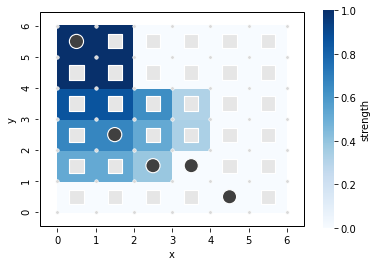

In [ ]:
m1 = Map(envs['A'])
update_map(m1, data[example_subj_ind].query('mode == "seek" and delivery == 0 and env == "A"'), [1.5, 0.1, 0.2]).plot();

What happens if we change the decay rate?

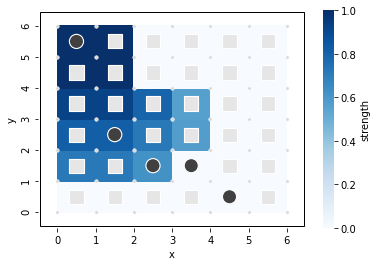

In [ ]:
m2 = Map(envs['A'])
update_map(m2, data[example_subj_ind].query('mode == "seek" and delivery == 0 and env == "A"'), [1.5, 0.05, 0.2]).plot();

When we implement the full model, Magellan will take 1-block steps from an intersection to an adjacent intersection.  We can use the `round_coords` function to round off each coordinate in a path to the nearest block.  This effectively "snaps" each path to traverse a series of adjacent intersections:

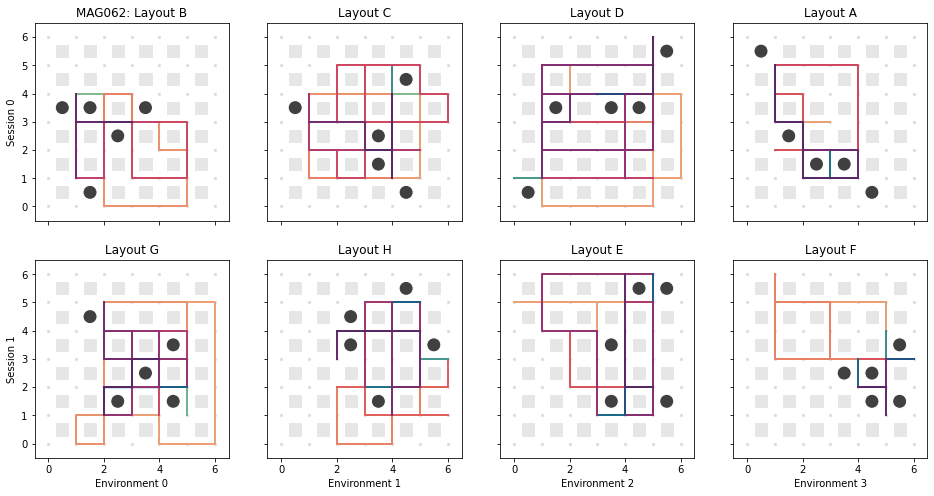

In [ ]:
ml.plot_paths(ml.round_coords(data[example_subj_ind]), envs);

## Part 3: putting the full model together

The `magellan` function implements the full model.  The function takes in the following inputs:
- `data`: a multi-subject dataset
- `envs`: a dictionary of environments
- `params`: a list of parameters (i.e., [$x_1$, $x_2$, $x_3$])
- `speed`: the navigation speed, specified in blocks per second (default: 0.25)
- `blocksize`: the length of one block, specified in arbitrary units (default: 1)
- `max_iter`: the maximum number of iterations of the main algorithm to run before timing out (default: 1000)

A new DataFrame is returned, in the same format as `data`, but with all "seek" paths (i.e., paths that each participant took to deliver each passenger) replaced with "autopilot" paths that are generated by MAGELLAN.

Your job will be to fill in the `arrived` and `navigate_to_target` functions:
- `arrived(path, target)`: returns `True` if the current path ends at the indicated location, and `False` otherwise:
  - `path`: a delivery path in the same format as used in the `path_distance` function and others.
  - `target`: a row (Series) of the `env` DataFrame containing information about the passenger's intended destination
  - The function works as follows:
    - First compute the intersections that are adjacent to the target
    - Second, compute the distances of each adjacent intersection to the target
    - Third, compute the distance of the last location in `path` (i.e., `path.iloc[-1]`) to the target
    - Finally, return `True` if the last location in `path` is as close (or closer) to the target as any of its adjacent intersections.  If the last location in `path` is farther than all adjacent intersections, return `False`.
- `navigate_to_target(path, target, speed, max_steps, blocksize)` appends new locations to `path` in order to "drive" to the indicated target:
  - `path` and `target`: defined the same as in `arrived`
  - `speed`: the driving speed (in blocks per second).  This is used to compute the indices (times) of the new additions to `path`.  Hint: `datetime.timedelta` will be useful for computing the timing of each step.
  - `max_steps`: the maximum number of 1-block steps to add to the existing path.  If this is set to less than the generated path to the target, the path to the target should be truncated to append no more than `max_steps` additional steps to `path`.  (Default: `np.inf`-- i.e., no limit on the maximum number of steps.)
  - `blocksize`: the length of one block, specified in arbitrary units (default: 1)
  - The function works as follows:
    - First, replace `path` with a copy of itself to prevent modification of the original DataFrame
    - Second, use `round_coords` to snap the last location in `path` to the nearest block.
    - Third, compute the closest intersection from the new, rounded-off, last location in `path` to the target.
    - Fourth, compute the horizontal and vertical distance (in blocks) from the current location to the target.  Let `h` be the horizontal distance and `v` be the vertical distance.
    - Fifth, set `n_steps = 0`
    - Sixth, while `n_steps < max_steps` and (`h` > 0 or `v` > 0):
      - If `h` > 0 and `v` > 0, take one horizontal (*x*) *or* vertical (*y*) step (of size `blocksize`) towards the target.
      - Otherwise, if `h` > 0 and `v` <= 0, take one horizontal step towards the target.
      - Otherwise, if `h` <= 0 and `v` > 0, take one vertical step towards the target.
      - Append the new location (including its updated timestamp) to `path`.  Decrement `h` or `v` as appropriate.  Increment `n_steps` by 1.
    - Finally, return the new `path`.
  - Note: "taking a step" really just means "appending a new row to `path`".  
  - Make sure to set `mode` to "autopilot" for any new steps that are appended to `path`.  That will enable plotting functions to recognize when paths are generated by MAGELLAN versus by the (real) participants.


In [ ]:
def magellan(data, envs, params, speed=0.25, blocksize=1, max_iter=1000):
  data = data.copy()
  
  def arrived(path, target):
    ### BEGIN YOUR CODE
    pass
    ### END YOUR CODE
  
  def navigate_to_target(path, target, speed, max_steps=np.inf, blocksize=1):
    path = path.copy()
    rounded = ml.round_coords(path.iloc[-1]) #round off last coordinate
    path = pd.concat([path, pd.DataFrame(rounded).T])    
    rounded['mode'] = 'autopilot'
    path = pd.concat([path, pd.DataFrame(rounded).T])

    ### BEGIN YOUR CODE
    pass
    ### END YOUR CODE
      
  def mag(data, params, speed):
    x1, x2, x3 = params #x1: vision; x2: decay; x3: min threshold        
    deliveries = ml.get_conditions(data, ['delivery'], unique=True)[0]
    
    path = pd.DataFrame(data.iloc[0]).T
    env = envs[path['env'][0]]
    
    prev_strengths = Map(env).strengths

    for d in deliveries:
      #reset map
      m = Map(env)
      m.strengths = prev_strengths
      
      #update map with previous (forage + seek) and current forage
      if d > np.min(deliveries):
        update_map(m, data.query(f'delivery == {d} - 1'), params)
      
      forage = data.query(f'delivery == {d} and mode == "forage"')
      update_map(m, forage, params)
      prev_strengths = m.strengths.copy()
      
      #add current forage to path            
      path = pd.concat([path, forage])
      
      seek = data.query(f'delivery == {d} and mode == "seek"')
      target_id = seek.iloc[0]['target']
      target = m.env.loc[target_id]
      
      #back up path            
      previous_path = path.copy()
      n_iter = 0
      while not (arrived(path, target) or (n_iter >= max_iter)):
        n_iter += 1
        
        current_time = path.index[-1]
        if m[target_id] > x3:
          path = navigate_to_target(path, target, speed)
        else:
          next_unknown = m.names[m.strengths <= x3].ravel()
          if len(next_unknown) > 0:
            next_unknown = closest_landmarks(path.iloc[-1][['x', 'y']], env.loc[next_unknown]).index.values

            destination_id = np.random.choice(next_unknown)
            destination = m.env.loc[destination_id]
            if not arrived(path, destination):
              path = navigate_to_target(path, destination, speed, max_steps=1)                                            
        
        new_steps = path.index >= current_time
        path['target'].loc[new_steps] = target_id
        
        if np.sum(new_steps) == 1:
          update_map(m, pd.DataFrame(path.loc[new_steps]), params)
        elif np.sum(new_steps) > 1:
          update_map(m, path.loc[new_steps], params)
        else: #no new steps; just decay memory strengths
          m.strengths = memory_decay(m.strengths, x2, 1 / speed)          
      
      if not arrived(path, target): #skip this delivery (max_iter reached)
        print(f"skipping {data.iloc[0]['subj']} session {data.iloc[0]['session']} env {data.iloc[0]['env']} delivery {d} (max iter reached)")
        path = previous_path
      else:
        print(f"completed {data.iloc[0]['subj']} session {data.iloc[0]['session']} env {data.iloc[0]['env']} delivery {d}")
    return path
  
  paths = ml.apply_by_condition(data, ['session', 'env_num', 'subj'], mag, [params, speed])
  return pd.concat(paths, axis=0)

### Running some simulations!

Without a [supercomputer](https://en.wikipedia.org/wiki/Supercomputer) like Dartmouth's [Discovery Cluster](https://rc.dartmouth.edu/index.php/discovery-overview/), it'll take too long to fit MAGELLAN to the full dataset we've explored here.  Instead, as a demonstration, we'll choose a set of pre-defined parameters and use them to simulate spatial learning for 10 participants.

In [ ]:
random.seed(1234)

params = [1.6, 0.07, 0.1]
n_subjs = 10
magpaths = magellan(pd.concat(data[:n_subjs]), envs, params)

Let's take a look at some examples of MAGELLAN's deliveries:

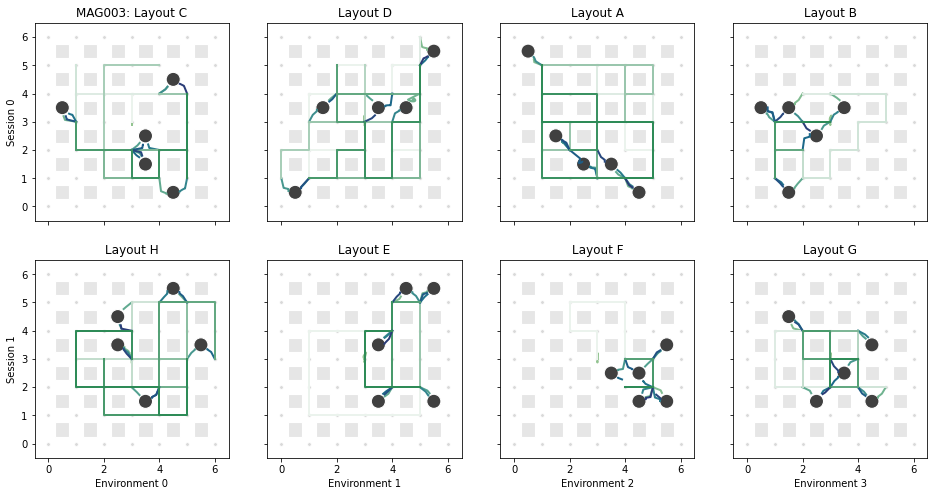

In [ ]:
ml.plot_paths(magpaths.query(f'subj == \'{magpaths.iloc[0]["subj"]}\''), envs);

Finally, we can compare the learning curves predicted by MAGELLAN (using a given set of parameters) versus the learning curves we actually observed.  To fairly compare the sets of learning curves, we'll use `round_coords` to round every coordinate along the participants' paths to the nearest block-- this ensures that the minimum achievable path length for any delivery is equal to the city block distance between the delivery's starting point and the closest adjacent intersection to the target store.

In [ ]:
mag_learning_curve = learning_curve(magpaths, envs)

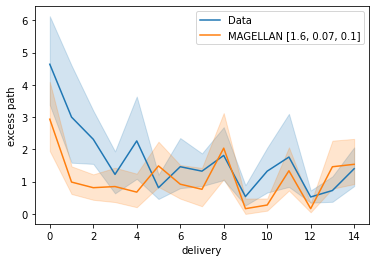

In [ ]:
rounded_learning_curve = learning_curve(ml.round_coords(pd.concat(data[:n_subjs])), envs)
sns.lineplot(data=rounded_learning_curve, x='delivery', y='excess path', legend=False);
sns.lineplot(data=mag_learning_curve, x='delivery', y='excess path', legend=False);
ax = mpl.pyplot.gca()
ax.legend(['Data', f'MAGELLAN {params}'])

# Closing thoughts

Think about the major differences between the modeling approaches we've explored here (decay functions versus MAGELLAN).  Which approach felt like a more "satisfying" explanation of how people might navigate?  Which approach felt more useful in practice?  How might either approach be improved upon?  How could you use these ideas in your own research projects?